In [4]:
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pybounds import Simulator, SlidingEmpiricalObservabilityMatrix, FisherObservability, SlidingFisherObservability, ObservabilityMatrixImage, colorline
import jax
import jax.numpy as jnp
def log_shapes(pytree):
    def log_leaf(path, leaf=()):
        if isinstance(leaf, jnp.ndarray) or isinstance(leaf, np.ndarray):
            print(f"Path: {path}, Shape: {leaf.shape}")
    jax.tree_util.tree_map_with_path(log_leaf, pytree)

# Define system dynamics and measurements
This example uses a model of an insect flying in the presence of wind.

See the following reference for details:

Floris van Breugel
A Nonlinear Observability Analysis of Ambient Wind Estimation with Uncalibrated Sensors, Inspired by Insect Neural Encoding
2021 60th IEEE Conference on Decision and Control (CDC)
DOI: 10.1109/CDC45484.2021.9683219

The system dynamics are described by seven primary states:
* altitude $z$
* parallel velocity $v_{\parallel}$
* perpendicular velocity $v_{\perp}$
* heading $\phi$
* angular velocity $\dot{\phi}$
* wind speed $w$
* wind direction $\zeta$

And the system dynamics are given by
$$
\dot{\mathbf{x}} = \begin{bmatrix} \dot{z} \\ \dot{v}_{\parallel} \\ \dot{v}_{\perp} \\ \dot{\phi} \\ \ddot{\phi} \\ \dot{w}  \\ \dot{\zeta} \end{bmatrix} = 
f(\mathbf{x}) = \begin{bmatrix} 
\dot{z} \\
\frac{1}{m}(k_{m_1}u_{\parallel} - C_{\parallel} a_{\parallel}) + v_{\perp} \dot{\phi} \\
 \frac{1}{m}(k_{m_3}u_{\perp} - C_{\perp} a_{\perp}) - v_{\parallel} \dot{\phi} \\
  \dot{\phi} \\
   \frac{1}{I}(k_{m_4}u_{\phi} - C_{\phi} \dot{\phi} + k_{m_2} u_{\perp}) \\
    \dot{w} \\
     \dot{\zeta} \\
\end{bmatrix}
$$

where the air velocity is given by

$$
\begin{bmatrix} a_{\parallel} \\ a_{\perp} \end{bmatrix} =  \begin{bmatrix} v_{\parallel} - w \cos(\phi - \zeta) \\ v_{\perp} + w \sin(\phi - \zeta) \end{bmatrix}
$$
The inputs $u_{\bullet}$ are
* parallel thrust force $u_{\parallel}$
* perpendicular thrust force $u_{\perp}$
* turning torque $u_{\phi}$

The inertia parameters (mass $m$ and inertia $I$), damping terms $C_{\bullet}$, and motor calibration coefficients $k_{m_{\bullet}}$ can also be considered states. Other auxiliary states, like the $x$ and $y$ position can also be added.

The putative system measurements are:
* heading $\phi$
* ground speed angle $\psi$
* apparent airflow angle $\gamma$
* apparent airflow magnitude $a$
* ground speed magnitude $g$
* optic flow $g/z$

Where the measurement function is given by:

$$
\mathbf{y} = h(\mathbf{x}) = \begin{bmatrix} \phi \\ \psi \\ \gamma  \\ a \\ g \\ r \end{bmatrix} = 
\begin{bmatrix} \phi \\
\arctan(v_{\perp}/ v_{\parallel}) \\
\arctan(a_{\perp} / a_{\parallel}) \\
\sqrt{a_{\parallel}^2 + a_{\perp}^2} \\
\sqrt{v_{\parallel}^2 + v_{\perp}^2} \\
\sqrt{v_{\parallel}^2 + v_{\perp}^2} / z \\
\end{bmatrix}
$$



## Define dynamics function
The dynamics function takes in a list of states $X$ and a list of inputs $U$ and outputs the derivative of the states.

The optional state & input names must be in the same order as the states & inputs in $X$ & $U$.

In [5]:
state_names = [
                'x',  # x position [m]
                'y',  # y position [m]
                'v_para',  # parallel ground velocity [m/s]
                'v_perp',  # perpendicular ground velocity [m/s]
                'phi', # heading [rad]
                'w',  # ambient wind speed [m/s]
                'zeta',  # ambient wind angle [rad]
                ]

input_names = [
                'u_para',  # translational speed [m/s]
                'u_phi',  # angular velocity [rad/s]
                'u_para_dot',  # translational acceleration [m/s^2] 
                'u_zeta_dot',
                'u_w_dot'  
                ]

def f(X, U):
    '''
    Return Xdot given X and U
    
    X: state vector
        v_para: ground velocity in the direction parallel to head direction (egocentric frame) [m/s]
        v_perp: ground velocity perpendicular to head direction (egocentric frame) [m/s]
        phi: heading [rad]
        w: wind speed [m/s]
        zeta: wind angle [rad]
    U: input vector assuming actions have been squashed and scaled
        u_para: translational speed [m/s]
        u_phi: angular velocity [rad/s]
        u_para_dot: translational acceleration [m/s^2]
    '''
    # States
    # v_para, v_perp, phi, w, zeta = X
    x, y, v_para, v_perp, phi, w, zeta = X
    
    # Inputs
    u_para, u_phi, u_para_dot, u_zeta_dot, u_w_dot = U # keep u_para because it is in the observation matrix

    # Dynamics
    w_dot = 0*w # wind speed is constant
    # w_dot = u_w_dot # wind speed is constant
    zeta_dot = u_zeta_dot # for discontinuous wind direction change
    phi_dot = u_phi # angular velocity is controlled by agent
    # v_perp_dot = - w * np.cos(phi - zeta) * u_phi # omit terms that would be zero
    v_perp_dot = -w * np.cos(phi - zeta) * u_phi + w * np.cos(phi - zeta) * zeta_dot - w_dot * np.sin(phi - zeta) 
    # v_para_dot = - w * np.sin(phi - zeta) * u_phi + u_para_dot # omit terms that would be zero
    v_para_dot = -w * np.sin(phi - zeta) * u_phi + w * np.sin(phi - zeta) * zeta_dot + w_dot * np.cos(phi - zeta) + u_para_dot
    x_dot = v_para * np.cos(phi) - v_perp * np.sin(phi)
    y_dot = v_para * np.sin(phi) + v_perp * np.cos(phi)

    # Package and return xdot
    X_dot = [x_dot, y_dot, v_para_dot, v_perp_dot, phi_dot, w_dot, zeta_dot]
    # X_dot = [v_para_dot, v_perp_dot, phi_dot, w_dot, zeta_dot]

    return X_dot

## Define measurement function
The measurement function takes in a list of states $X$ and a list of inputs $U$ and outputs the measurements $Y$.

The optional measurement names must be in the same order as the measurements in $Y$.

In [6]:
measurement_names = ['phi', 'appWind', 'psi'] # heading, apparent wind parallel component, drift angle/egocentric course angle
def h(X, U):
    '''
    Measurement functions - input is the state and control input; output is the measurement
    Assuming control signals are squashed and scaled
    '''
    # States
    x, y, v_para, v_perp, phi, w, zeta = X
    # v_para, v_perp, phi, w, zeta = X
    
    # Inputs
    u_para, u_phi, u_para_dot, u_zeta_dot, u_w_dot = U
    
    # Measurements
    # Heading
    phi = phi # heading is directly observable 
    # Apparent wind
    appWind = - u_para # equal and opposite to translational speed which is in line with head direction and thus have only a parallel component
    # Course direction in fly reference frame
    psi = np.arctan2(v_perp, v_para) # drift angle / egocentric course angle  # TODO numerically check if this is actually the drift angle - yes according to Ben
    
    # # Unwrap angles - Elliot unwrap the angles s.t. they are continuous - no more snapping back to 0
    if np.array(phi).ndim > 0:
        if np.array(phi).shape[0] > 1:
            phi = np.unwrap(phi)
            psi = np.unwrap(psi)
    #         # gamma = np.unwrap(gamma)

    # Measurements
    Y  = [phi, appWind, psi]

    # Return measurement
    return Y


## Set time-step

In [7]:
dt = 0.04  # [s]

# Create simulator object

In [8]:
simulator = Simulator(f, h, dt=dt, state_names=state_names, input_names=input_names, measurement_names=measurement_names)

# Can also set the number of state (n) & inputs (m0 instead of state & input names)
# simulator = Simulator(f, h, dt=dt, n=len(state_names), m=len(input_names))

# Load inference-time trajectories to pull out control signals

In [9]:
log_fname = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/noisy3x5b5.pkl'
# load pkl file
import pickle
import numpy as np
with open(log_fname, 'rb') as f_handle:
    episode_logs = pickle.load(f_handle)
print('Loaded episode logs from', log_fname)
print('Number of episodes:', len(episode_logs))
print('Episodes contain:', episode_logs[0].keys())
print('For more info on pkl content see /src/JH_boilerplate/dev_test/env/explore_pkl.ipynb')
# episode_logs

Loaded episode logs from /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/noisy3x5b5.pkl
Number of episodes: 240
Episodes contain: dict_keys(['trajectory', 'observations', 'actions', 'rewards', 'infos', 'activity'])
For more info on pkl content see /src/JH_boilerplate/dev_test/env/explore_pkl.ipynb


In [10]:
raw_actions = episode_logs[1]['actions']
# TODO: function that squashes and scales actions. output is u_sim a dict with keys 'u_para', 'u_phi', 'u_para_dot', and values are np arrays
# stack a list of actions into a 2D array
raw_actions = np.stack(raw_actions)

def squash_and_scale_actions(raw_actions, dt):
    '''
    See /src/JH_boilerplate/dev_test/env/explore_pkl.ipynb
    
    Logged actions are the raw outputs of the agent. They need to be translated into the control inputs for the simulator.
    1. Squash the actions to [0, 1]
    2. Scale the actions to the fly's capabilities
    3. Calculate the translational acceleration - new need to be checked
    4. Return a dictionary of control inputs for the simulator
    
    Note at agent_angle_rad_t0, this is obtained by the following steps:
      - t = -1: env generates an obs by env.reset()
      - t = 0: policy creates an action based on the obs
      - t = 0: env.step(action)
          - t = 0: obs_t0 = obs_t(-1) + action_t0  (obs_t-1 based on how the angle was initialized which is NOT documented in the eps logs)
      - t = 1: env generates an obs
    '''
    
    def squash_action(x):
      return np.clip((np.tanh(x) + 1)/2, 0.0, 1.0) # squash action, center and scale to [0, 1], per action treatment 

    if type(raw_actions) is list:
      raw_actions = np.stack(raw_actions)
      
    # Vectorize the function # TODO sanity check
    vsquash_action = np.vectorize(squash_action)

    # Apply the vectorized function to the array
    actions = vsquash_action(raw_actions)

    # Scale actions by fly capabilities 
    actions[:, 0] = actions[:, 0] * 2.0 # Max agent speed in m/s
    actions[:, 1] = (actions[:, 1] - 0.5) * 6.25*np.pi # Max agent CW/CCW turn per second

    # Calculate translational acceleration
    acc = np.diff(actions[:, 0]) / dt # checked - this is correct
    # acc = np.insert(acc, 0, 0) # first acceleration is 0
    
    # Omit the first action. See function description.
    u_sim = {'u_para': actions[1:, 0], 'u_phi': actions[1:, 1], 'u_para_dot': acc} 
    print('u_sim shapes', u_sim['u_para'].shape, u_sim['u_phi'].shape, u_sim['u_para_dot'].shape)
    
    return u_sim

u_sim = squash_and_scale_actions(raw_actions, dt) # can be pulled from traj_df_stacked['step'] and 'turn'; just need to scale but already squashed

u_sim shapes (121,) (121,) (121,)


# Pull out ground truth states and measurements to be simulated 

In [11]:
import tamagotchi.eval.log_analysis as log_analysis
number_of_eps = 240 # pull all episodes
dataset = 'noisy3x5b5'
# dataset = 'constantx5b5'
exp_folder = 'eval'
model_fname = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/weights/plume_14421_37e2cd4be4c96943d0341849b40f81eb.pt'
# traj_df_stacked = log_analysis.get_eval_dfs_and_stack_them(model_fname, dataset, number_of_eps, exp_dir=exp_folder, # full_model_dir = args.model_dir, 
#                                                            oob_only=False,
#                                                            balanced=False,
#                                                            verbose=True) # this uses get_traj_tmp

# based on open_loop_perturbation.py
eval_folder = model_fname.replace('weights', exp_folder).replace('.pt', '/')
selected_df = log_analysis.get_selected_df(eval_folder, [dataset],
                                        n_episodes_home=240,
                                        n_episodes_other=240,  
                                        balanced=False,
                                        oob_only=False,
                                        verbose=True)

# traj_df_stacked2, stacked_neural_activity = log_analysis.get_traj_and_activity_and_stack_them(selected_df, 
traj_df_stacked, stacked_neural_activity = log_analysis.get_traj_and_activity_and_stack_them(selected_df, 
                                                                                            obtain_neural_activity = True, 
                                                                                            obtain_traj_df = True, 
                                                                                            get_traj_tmp = True,
                                                                                            extended_metadata = True) # get_traj_tmp 

# twp methods of getting traj are not equivalent - get_eval_dfs_and_stack_them has loc_x/y_dot
    # get_traj_and_activity_and_stack_them has tidx
    # the columns used for simulator are identical
# cols1 = traj_df_stacked.columns
# cols2 = traj_df_stacked_2.columns
# unique_cols1 = [col for col in cols1 if col not in cols2]
# unique_cols2 = [col for col in cols2 if col not in cols1]
# print('unique_cols1', unique_cols1)
# print('unique_cols2', unique_cols2)

epoch_traj_df = traj_df_stacked[traj_df_stacked['ep_idx'] == 1]
epoch_latent_activity = stacked_neural_activity[epoch_traj_df.index]

Found                     idx  ep_length  log
dataset    outcome                     
noisy3x5b5 HOME     160        160  160
           OOB       74         74   74
           OOT        6          6    6 in /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb//noisy3x5b5.pkl, after filter by min 0 steps
Found                     idx  ep_length  log
dataset    outcome                     
noisy3x5b5 HOME     160        160  160
           OOB       74         74   74
           OOT        6          6    6 in /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb//noisy3x5b5.pkl, after selecting specific number of episodes
model_dir /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2

240it [00:06, 35.45it/s]


In [12]:
gt_dict = {'x':[], 'y':[], 'v_para': [], 'v_perp': [], 'phi': [], 'w': [], 'zeta': [], 
           'psi_ego_course_dir': [], 'v_allo': []}

# gt_dict = {'v_para': [], 'v_perp': [], 'phi': [], 'w': [], 'zeta': [], 'psi_ego_course_dir': [], 'v_allo': []}

gt_dict['x'] = epoch_traj_df['loc_x'].values
gt_dict['y'] = epoch_traj_df['loc_y'].values
gt_dict['phi'] = np.angle(epoch_traj_df['agent_angle_x'] + 1j*epoch_traj_df['agent_angle_y'], deg=False)
gt_dict['w'] = np.round(epoch_traj_df['wind_speed_ground'].values, 3)
gt_dict['zeta'] = epoch_traj_df['wind_angle_ground_theta'].values # normalized by pi and then shifted to 0-1
gt_dict['psi_ego_course_dir'] = epoch_traj_df['ego_course_direction_theta'].values # normalized by pi and then shifted to 0-1
gt_dict['v_allo'] = np.stack(epoch_traj_df['allo_ground_velocity'].values) # PEv3: (np.array(self.agent_location) - self.agent_location_last)/self.dt; calc'd in get_eval_dfs_and_stack_them
gt_dict['v_allo_dt'] = np.diff(gt_dict['v_allo']) / dt # acceleration
# scale angles from 0-1 to -pi to pi
gt_dict['zeta'] = np.pi * (2*gt_dict['zeta'] - 1)
gt_dict['psi_ego_course_dir'] = np.pi * (2*gt_dict['psi_ego_course_dir'] - 1)

gt_dict['v_para'] = np.cos(gt_dict['psi_ego_course_dir']) * np.linalg.norm(np.stack(gt_dict['v_allo']), axis=1) # cos(psi) * g = v_para
gt_dict['v_perp'] = np.sin(gt_dict['psi_ego_course_dir']) * np.linalg.norm(np.stack(gt_dict['v_allo']), axis=1) # sin(psi) * g = v_perp

u_sim['u_zeta_dot'] = np.diff(gt_dict['zeta']) / dt
u_sim['u_w_dot'] = np.diff(gt_dict['w']) / dt
log_shapes(gt_dict) # expected to have one more time point at the end
log_shapes(u_sim) # 0th control signal is omitted
# log_shapes(gt_dict)

Path: (DictKey(key='phi'),), Shape: (122,)
Path: (DictKey(key='psi_ego_course_dir'),), Shape: (122,)
Path: (DictKey(key='v_allo'),), Shape: (122, 2)
Path: (DictKey(key='v_allo_dt'),), Shape: (122, 1)
Path: (DictKey(key='v_para'),), Shape: (122,)
Path: (DictKey(key='v_perp'),), Shape: (122,)
Path: (DictKey(key='w'),), Shape: (122,)
Path: (DictKey(key='x'),), Shape: (122,)
Path: (DictKey(key='y'),), Shape: (122,)
Path: (DictKey(key='zeta'),), Shape: (122,)
Path: (DictKey(key='u_para'),), Shape: (121,)
Path: (DictKey(key='u_para_dot'),), Shape: (121,)
Path: (DictKey(key='u_phi'),), Shape: (121,)
Path: (DictKey(key='u_w_dot'),), Shape: (121,)
Path: (DictKey(key='u_zeta_dot'),), Shape: (121,)


# Compare control signals with ground truth - acc and step check out

In [13]:
# u_para_dot is calculated correctly in that it matches the airspeed acceleration of the agent
    # the airspeed acceleration of the agent checked out in that it pointed in the head direction
air_velocity = np.stack(epoch_traj_df['air_velocity'].values)
air_velocity_angle = np.angle(air_velocity[:, 0] + 1j*air_velocity[:, 1], deg=False)
air_velocity_mag = np.linalg.norm(air_velocity, axis=1)
air_velocity_acc = np.diff(air_velocity_mag) / dt
print(np.allclose(air_velocity_acc, u_sim['u_para_dot'], atol=1e-4))

agent_angle = np.angle(epoch_traj_df['agent_angle_x'].values + 1j*epoch_traj_df['agent_angle_y'].values, deg=False)
print(np.allclose(air_velocity_angle, agent_angle, atol=1e-4))

True
True


In [14]:
# get acceleration in airspeed from ground truth
epoch_traj_df['step_scaled'] = epoch_traj_df['step'] * 2
epoch_traj_df['u_para_dot'] = epoch_traj_df['step_scaled'].diff() / dt

# are epoch_traj_df['u_para_dot'] and u_sim['u_para_dot'] the same, allow for a small tolerance? YES
print(np.allclose(epoch_traj_df['u_para_dot'].values[1:], u_sim['u_para_dot'], atol=1e-4)) 

True


# Simulate with control inputs to see if it matches ground truth

In [15]:
# x0 = np.array([gt_dict['x'][0], gt_dict['y'][0], gt_dict['v_para'][0], gt_dict['v_perp'][0], gt_dict['phi'][0], gt_dict['w'][0], gt_dict['zeta'][0]])
x0 = {'x': gt_dict['x'][0], 'y': gt_dict['y'][0], 'v_para': gt_dict['v_para'][0], 'v_perp': gt_dict['v_perp'][0], 'phi': gt_dict['phi'][0], 'w': gt_dict['w'][0], 'zeta': gt_dict['zeta'][0]}
# x0 = np.array([gt_dict['v_para'][0], gt_dict['v_perp'][0], gt_dict['phi'][0], gt_dict['w'][0], gt_dict['zeta'][0]])

In [16]:
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=x0, mpc=False, u=u_sim, return_full_output=True)

In [17]:
# Plot state
# simulator.plot('x')

# Plot the ground truth and the simulated trajectories

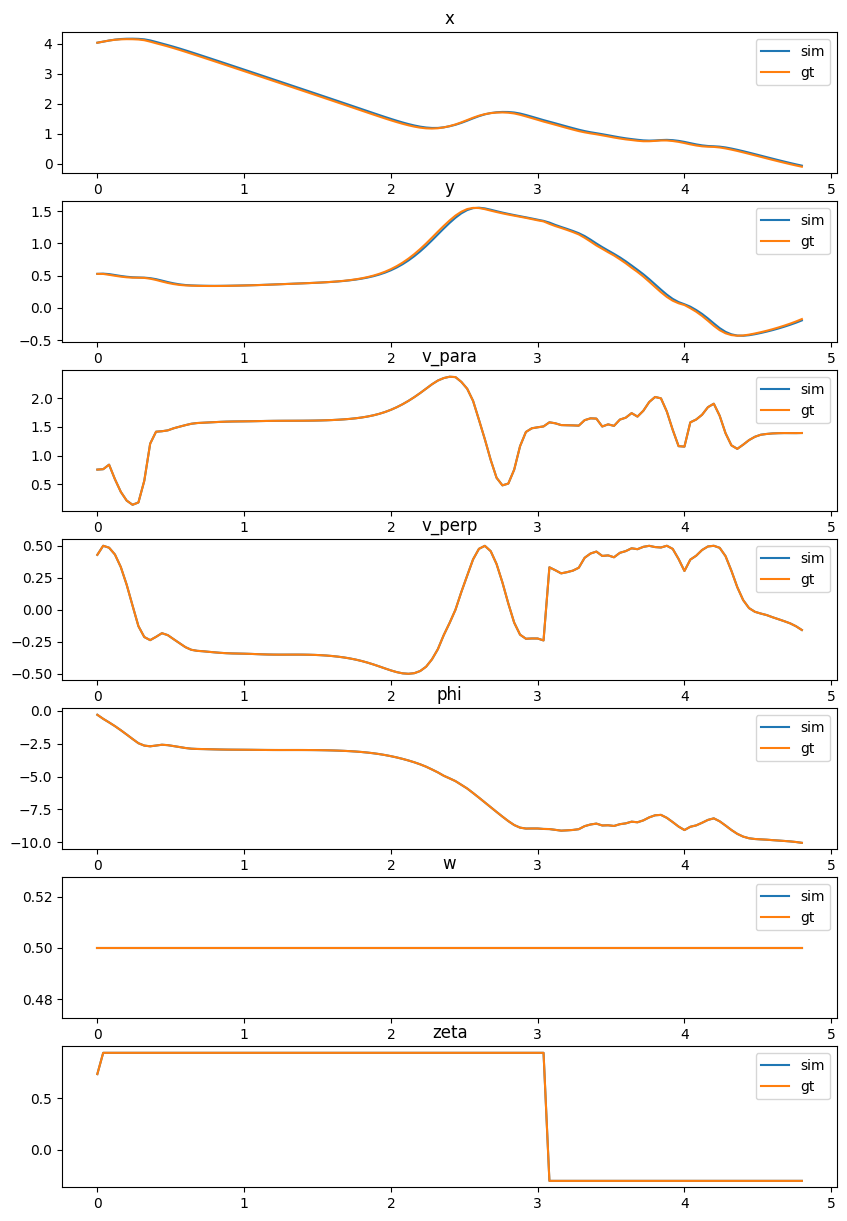

In [18]:
# plot ground truth
# plot each state in a separate plot, where x_sim is a dict 
gt_dict['phi'] = np.unwrap(gt_dict['phi'])
fig, axs = plt.subplots(7, 1, figsize=(10, 15)) # x y loc
# fig, axs = plt.subplots(5, 1, figsize=(10, 15))
for i, state_name in enumerate(state_names):
    axs[i].plot(t_sim, x_sim[state_name], label='sim')
    axs[i].plot(t_sim, gt_dict[state_name][:-1], label='gt')
    axs[i].set_title(state_name)
    axs[i].legend()
plt.show()

# Observability

## Construct observability matrix in sliding windows

In [19]:
w = 10  # window size, set to None to use entire time-series as one window

In [20]:
# Construct O in sliding windows
st = time.time()
SEOM = SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-6)
et = time.time()
print('elapsed time:', et-st)

elapsed time: 12.670354127883911


In [21]:
# Get O's
O_sliding = SEOM.get_observability_matrix()

In [22]:
n_window = len(O_sliding)
print(n_window, 'windows')

112 windows


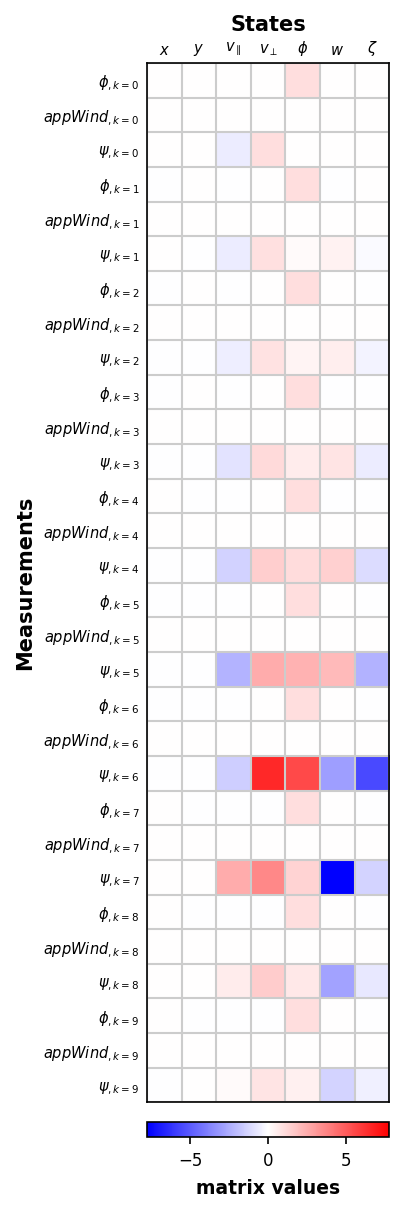

In [23]:
# Visualize first sliding observability matrix, this will throw errors if O is too big
OI = ObservabilityMatrixImage(O_sliding[0], cmap='bwr')
OI.plot(scale=1.0)

## Compute Fisher information matrix & inverse for first window


In [24]:
# Set each sensor noise level
sensor_noise = {'phi': 0, 'appWind': 0, 'psi': 0}
# sensor_noise = {'phi': 0.1, 'appWind': 0.1, 'psi': 0.1}

In [25]:
SEOM.O_df_sliding[0]

,,x,y,v_para,v_perp,phi,w,zeta
sensor,time_step,,,,,,,
phi,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000e+00
appWind,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
psi,0,0.000000e+00,0.000000e+00,-5.676239e-01,1.000372e+00,0.000000,0.000000e+00,0.000000e+00
phi,1,-2.220446e-10,0.000000e+00,-2.220446e-10,0.000000e+00,1.000000,-2.220446e-10,3.330669e-10
appWind,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
psi,1,0.000000e+00,-1.110223e-10,-6.004741e-01,9.169458e-01,0.180904,4.223692e-01,-1.809045e-01
phi,2,-2.775558e-10,0.000000e+00,-1.110223e-10,5.551115e-11,1.000000,5.551115e-11,-5.551115e-11
appWind,2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
psi,2,-5.551115e-10,-3.552714e-09,-5.134851e-01,8.916664e-01,0.308580,4.882377e-01,-3.085799e-01


In [26]:
# Compute the Fisher information & Chernoff inverse
FO = FisherObservability(SEOM.O_df_sliding[0], R=None, sensor_noise_dict=sensor_noise, lam=1e-12)

# Can also set R directly as matrix or as scalar
# FO = FisherObservability(SEOM.O_df_sliding[0], R=0.1*np.eye(O_sliding[0].shape[0]), lam=1e-6)
FO = FisherObservability(SEOM.O_df_sliding[0], R=0.1, lam=1e-6)

In [27]:
# Get the Fisher information, inverse, and R matrix
F, F_inv, R = FO.get_fisher_information()
F_inv

,x,y,v_para,v_perp,phi,w,zeta
x,999999.999991,-0.000007,-3.904595e-04,-3.049380e-05,2.775558e-05,1.713703e-04,-0.000645
y,-0.000007,999999.999806,-1.593005e-03,-2.665188e-04,9.325875e-04,2.301024e-03,-0.002485
v_para,-0.000390,-0.001593,8.533747e-01,3.436530e-01,2.334081e-09,4.349719e-01,-0.054685
v_perp,-0.000030,-0.000267,3.436530e-01,1.685985e-01,7.470481e-10,1.816921e-01,0.012836
phi,0.000028,0.000933,2.334081e-09,7.470481e-10,1.000000e-02,4.147635e-10,0.010000
w,0.000171,0.002301,4.349719e-01,1.816921e-01,4.147635e-10,2.244591e-01,-0.021078
zeta,-0.000645,-0.002485,-5.468465e-02,1.283578e-02,9.999999e-03,-2.107752e-02,0.056620


## Compute Fisher information matrix & inverse for each sliding window

In [28]:
# Choose sensors to use from O
o_sensors = ['phi', 'appWind', 'psi']

# Chose states to use from O
o_states = [
                # 'x',  # x position [m]
                # 'y',  # y position [m]
                'v_para',  # parallel ground velocity [m/s]
                'v_perp',  # perpendicular ground velocity [m/s]
                # 'phi', # heading [rad]
                'w',  # ambient wind speed [m/s]
                'zeta',  # ambient wind angle [rad]
                ]

# Choose time-steps to use from O
window_size = 10
o_time_steps = np.arange(0, window_size, step=1)

In [29]:
# Compute the Fisher information & inverse for each window and store the minimum error variance
# SFO = SlidingFisherObservability(SEOM.O_df_sliding, time=SEOM.t_sim, lam=1e-6, R=None, sensor_noise_dict=sensor_noise,
SFO = SlidingFisherObservability(SEOM.O_df_sliding, time=SEOM.t_sim, lam=1e-6, R=0.1, #sensor_noise_dict=sensor_noise,
                                 states=o_states, sensors=o_sensors, time_steps=o_time_steps, w=None)

In [30]:
# Pull out minimum error variance, 'time' column is the time vector shifted forward by w/2 and 'time_initial' is the original time
EV_aligned = SFO.get_minimum_error_variance()

In [31]:
EV_aligned

,time,time_initial,v_para,v_perp,w,zeta
0,0.00,NaN,NaN,NaN,NaN,NaN
1,0.04,NaN,NaN,NaN,NaN,NaN
2,0.08,NaN,NaN,NaN,NaN,NaN
3,0.12,NaN,NaN,NaN,NaN,NaN
4,0.16,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
116,4.64,4.44,116118.650296,11.205918,15370.213376,849.49249
117,4.68,NaN,NaN,NaN,NaN,NaN
118,4.72,NaN,NaN,NaN,NaN,NaN
119,4.76,NaN,NaN,NaN,NaN,NaN


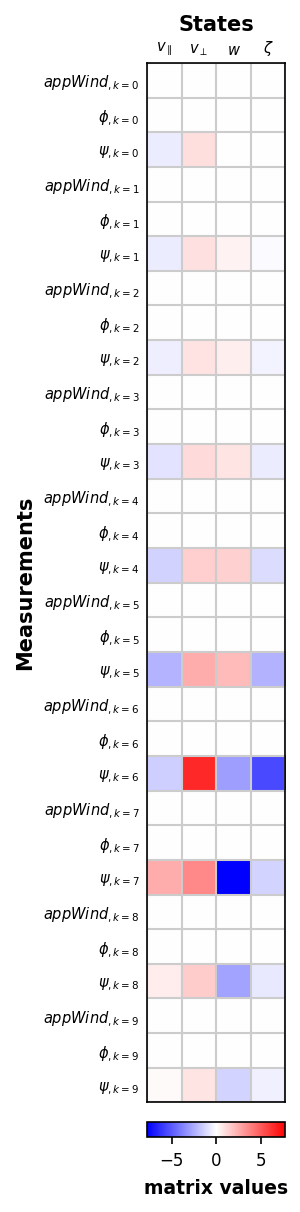

In [32]:
# Visualize observability matrix subset
OI = ObservabilityMatrixImage(SFO.FO[0].O)
OI.plot()

# Plot error variance as color on state time-series

In [33]:
EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

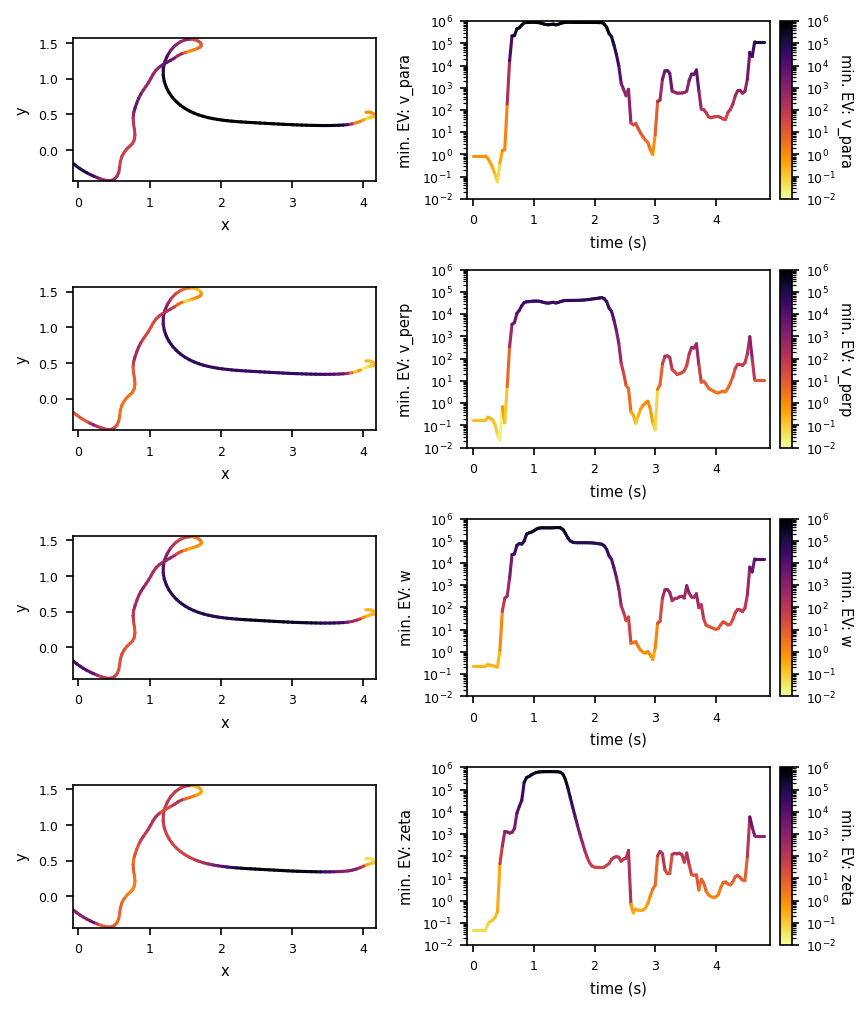

In [34]:
states = list(SFO.FO[0].O.columns)
n_state = len(states)

fig, ax = plt.subplots(n_state, 2, figsize=(6, n_state*2), dpi=150)
ax = np.atleast_2d(ax)

cmap = 'inferno_r'

min_ev = np.min(EV_no_nan.iloc[:, 2:].values)
max_ev = np.max(EV_no_nan.iloc[:, 2:].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(t_sim, x_sim[state_name], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(x_sim['x'], x_sim['y'], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values, ax=ax[n, 1], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)
    
    ax[n, 0].set_ylim(np.min(x_sim['y']) - 0.01, np.max(x_sim['y']) + 0.01)
    ax[n, 0].set_xlim(np.min(x_sim['x']) - 0.01, np.max(x_sim['x']) + 0.01)
    ax[n, 0].set_ylabel('y', fontsize=7)
    ax[n, 0].set_xlabel('x', fontsize=7)
    ax[n, 0].set_aspect(1.0)

    ax[n, 1].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 1].set_yscale('log')
    ax[n, 1].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 1].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 1]:
    a.set_xlabel('time (s)', fontsize=7)
    a.set_xlim(-0.1, t_sim[-1] + 0.1)
    
# for a in ax[:, 1]:
#     a.set_xlim(-0.1, t_sim[-1] + 0.1)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

# Colorize the neural trajectory based on the theoretical minimum error variance

In [158]:
from natsort import natsorted
import tamagotchi.config as config
np.random.seed(config.seed_global)
# Common
import importlib
importlib.reload(config)
outcome_colormap = config.outcome_colormap
regime_colormap = config.regime_colormap
import os
# Common
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style="white")
# print(plt.style.available)

mpl.rcParams['figure.dpi'] = 100
dpi_save = 300
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)

# Interactive vs. CLI

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
%config InlineBackend.figure_format = 'retina'

pca3d_figsize=(10,5)



# https://seaborn.pydata.org/generated/seaborn.set_color_codes.html#seaborn.set_color_codes
sns.color_palette()
sns.set_color_codes(palette='deep')

import glob

log_fname = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/constantx5b5.pkl'

seed='14421'
model_fname = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/weights/plume_14421_37e2cd4be4c96943d0341849b40f81eb.pt'
# diffusionx = 0.5
print(model_fname)
# print("diffusionx ---->", diffusionx)

model_dir = model_fname.replace('.pt', '/')
print("model_dir", model_dir)

eval_dir = model_dir.replace('weights', exp_folder)

model_seed = model_dir.rstrip('/').split('/')[-1].split('_')[1]
print("model_seed ---->", model_seed)

# outdir = f"{model_dir}/report_common_subspace/"
# indir = f'{model_dir}/report_arch/' # to get best_window_lengths from report_correlations
# os.makedirs(outdir, exist_ok=True)
# print(f"Outputing to {outdir}")

is_recurrent = True
# logfiles = natsorted(glob.glob(model_dir + '*.pkl'))
# [ x.split('/')[-1] for x in logfiles ]

/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/weights/plume_14421_37e2cd4be4c96943d0341849b40f81eb.pt
model_dir /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/weights/plume_14421_37e2cd4be4c96943d0341849b40f81eb/
model_seed ----> 14421


In [159]:
use_datasets = ['noisy3x5b5']
# use_datasets = ['constantx5b5', 'switch45x5b5', 'noisy3x5b5']

print(model_seed)
selected_df = log_analysis.get_selected_df(eval_dir, 
                              use_datasets, 
                              n_episodes_home=240, 
                              n_episodes_other=240,
                              min_ep_steps=0,
                              balanced=False,
                              oob_only=False,
                              verbose =True) # get the pkl files 
print(selected_df.shape)

14421


Found                     idx  ep_length  log
dataset    outcome                     
noisy3x5b5 HOME     160        160  160
           OOB       74         74   74
           OOT        6          6    6 in /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb//noisy3x5b5.pkl, after filter by min 0 steps
Found                     idx  ep_length  log
dataset    outcome                     
noisy3x5b5 HOME     160        160  160
           OOB       74         74   74
           OOT        6          6    6 in /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb//noisy3x5b5.pkl, after selecting specific number of episodes
model_dir /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2

[4]


Text(0, 0.5, 'Var. Explained [Fraction]')

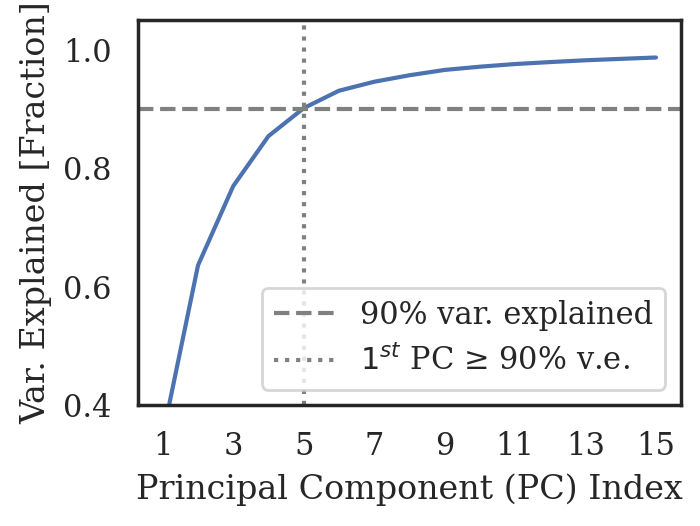

In [160]:
pca_common = log_analysis.get_pca_common(selected_df, 
                            n_comp=15, 
                            is_recurrent=is_recurrent)

epoch_latent_activity_common_pca = pca_common.transform(epoch_latent_activity[:-1])

# def plot_scree(pca_common):
cum_evr=np.cumsum(pca_common.explained_variance_ratio_)
n_comp=len(pca_common.explained_variance_ratio_)

fig = plt.figure(figsize=(3.5,2.5))
plt.plot(cum_evr)
ax = plt.gca()
ax.set_xticks(np.arange(n_comp, step=2, dtype=int));
ax.set_xticklabels(np.arange(n_comp, step=2, dtype=int) + 1);
ax.axhline(0.90, ls='--', c='grey', label='90% var. explained')
plt.ylim(0.4, 1.05)

pc_over = np.argwhere(list(cum_evr >= 0.9))[0]
print(pc_over)
ax.axvline(pc_over, ls=':', c='grey', label='$1^{st}$ PC ≥ 90% v.e.')

plt.legend(loc='lower right')
plt.xlabel("Principal Component (PC) Index")
plt.ylabel("Var. Explained [Fraction]")


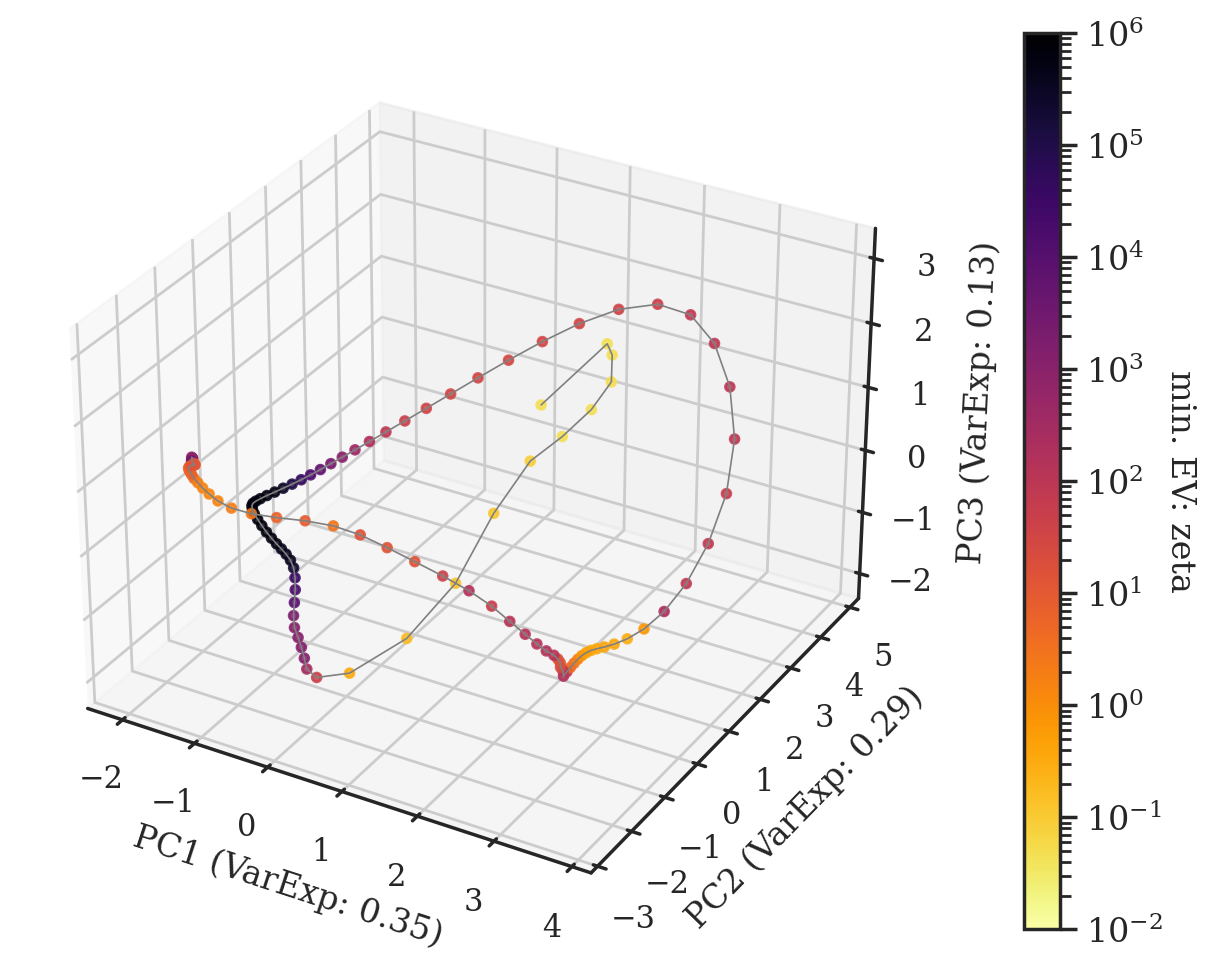

In [161]:
column_to_titlestring = {
    'odor_lastenc': 'Steps since last\nplume encounter',
    'stray_distance': 'stray_distance', 
    'odor_01': 'On/off plume',
    'odor_ma': 'Odor concentration MA [A.U.]',
    'odor_ewm': 'Odor concentration EWMA [A.U.]',
    'odor_enc': 'Odor encounters EWMA [A.U.]',
    'wind_theta_obs': 'Egocentric\nwind angle [rad]',
    'agent_angle_ground': r'Head direction [rad]',
    'turn': 'Turn',
    'step': 'Step',
    'neural_velocity': r"$\Delta$h",
    'ego_course_direction_theta': 'Course direction [rad]',
    'wind_angle_ground_theta': 'Wind direction [rad]',
    'zeta': 'Wind angle [rad]',
}

column_ticklabels = {
    'agent_angle_ground': [r'$-\pi/2$', 0, r'$+\pi/2$'],
}

column_ticks = {
    'agent_angle_ground': [0, 0.5, 1.0],
}


log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

# for n, state_name in enumerate(states):
#     # colorline(t_sim, x_sim[state_name], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
#     colorline(x_sim['x'], x_sim['y'], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
#     colorline(t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values, ax=ax[n, 1], cmap=cmap, norm=cnorm)

#     # Colorbar
#     cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
#     cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
#                         ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
#     cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
#     cbar.ax.tick_params(labelsize=6)
    
    
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def plot_common_subspace_from_traj_neural_dfs(epoch_latent_activity_common_pca, EV_no_nan, colorby, save=True):
    fig = plt.figure(figsize=pca3d_figsize)
    ax = fig.add_subplot(projection='3d')
    colorby_prefix = None
    
    X_pca = epoch_latent_activity_common_pca

    ax.plot(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], linewidth=0.6, c='grey', alpha=1.0)


    c = EV_no_nan['zeta'].values
    threshold = 10 # minEV threshold in radian 
    c_mapped = np.ma.masked_where(c > threshold, c)
    sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], s=10, 
                    c=c, 
                    alpha=0.85, norm=cnorm, cmap = 'inferno_r')
#     cbar_ax = inset_axes(ax, 
#                             width="30%", 
#                             height="3%", 
# #                              loc='upper right',
#                             bbox_to_anchor=(0.0, 0.45, 0.92, 0.4), # (x0, y0, width, height)
#                             bbox_transform=ax.transAxes,
#                         )
    # clb = plt.colorbar(sc, cbar_ax, orientation='horizontal') # ticks=[0., 1.]
    cax = ax.inset_axes([1.12, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=12, labelpad=12)
    cbar.ax.tick_params(labelsize=12)
    # move color bar to the right using inset_axes
    
    

    # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    # plt.colorbar(sc, cax=cax)

    ax.set_xlabel(f'PC1 (VarExp: {pca_common.explained_variance_ratio_[0]:0.2f})')
    ax.set_ylabel(f'PC2 (VarExp: {pca_common.explained_variance_ratio_[1]:0.2f})')
    ax.set_zlabel(f'PC3 (VarExp: {pca_common.explained_variance_ratio_[2]:0.2f})')
#     plt.legend()
    plt.tight_layout()


    plt.show()
    if save:
        fname = f"{outdir}/comsub_{colorby}_{model_seed}.png"
        print("Saving:", fname)
        fig.savefig(fname, dpi=dpi_save, bbox_inches='tight', transparent=False)

    # Just plot colorbar
#     if colorby not in ['outcome', 'regime']:
#         fig = plt.figure()
#         ax = plt.gca()
#         sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], 
#                     s=10, c=c, cmap='copper', alpha=0.5, vmin=0)
#         plt.colorbar(sc, orientation='horizontal') # ticks=[0., 1.]

#         fname = f"{outdir}/comsub_{colorby}_{model_seed}_colorbar.png"
#         print("Saving:", fname)
#         plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')


    


plot_common_subspace_from_traj_neural_dfs(epoch_latent_activity_common_pca,  EV_no_nan, 'zeta', save=False)



turn 0.02317968 0.7973819
turn 0.037458867 0.81634086
turn 0.08487731 0.8951648
turn 0.02169782 0.9139704
turn 0.021427035 0.9445936
turn 0.020901322 0.93173176
turn 0.09372252 0.91499585
turn 0.018130332 0.953359
turn 0.021123499 0.92082405
turn 0.021649092 0.94872856
turn 0.021397024 0.82099664
turn 0.021542102 0.8726414
turn 0.019614637 0.93874645
turn 0.020620793 0.8548972
turn 0.06939852 0.90698934
turn 0.071866065 0.90977734
turn 0.060385317 0.9055239
turn 0.072634935 0.9377919
turn 0.057965845 0.9601466
turn 0.05652848 0.9658577
Here1


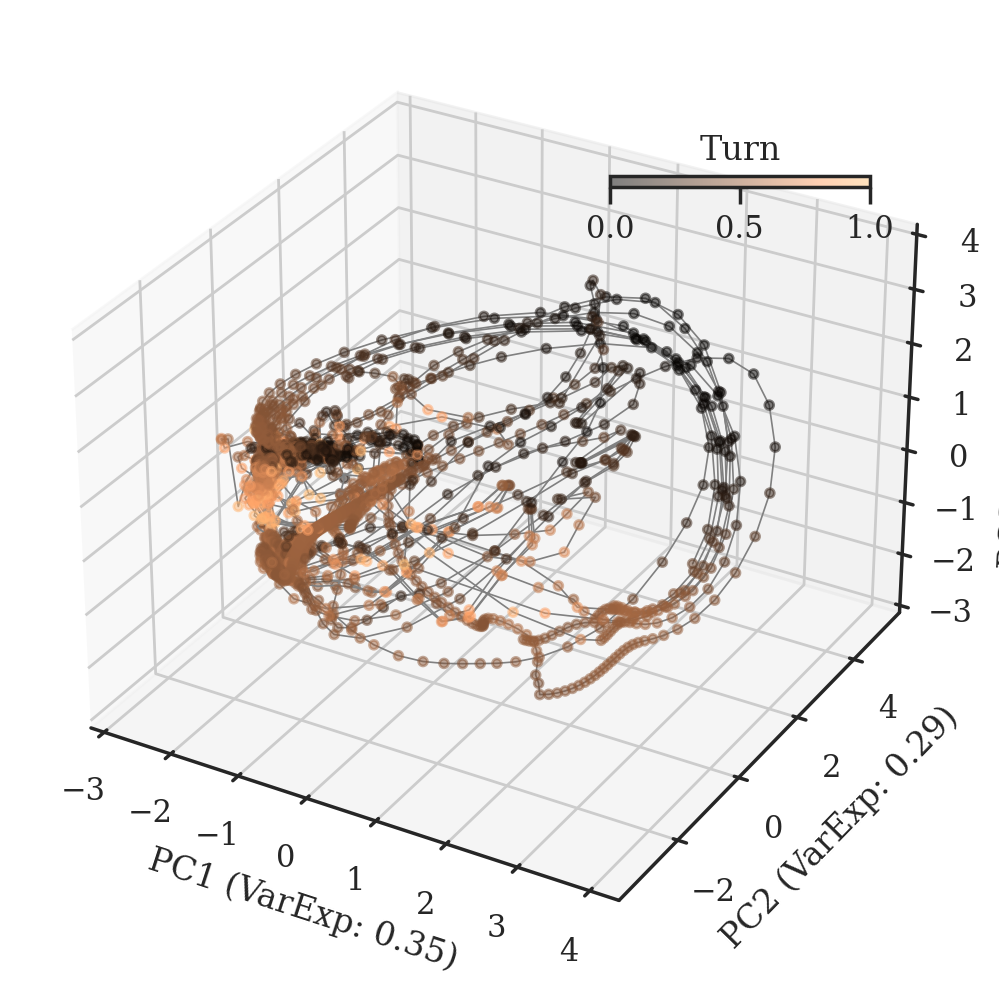

In [165]:
# Plot neural-trajectories on common subspace
# %matplotlib notebook 
# importlib.reload(log_analysis)

# %config InlineBackend.figure_format = 'retina' # For manuscript
# mpl.rcParams['figure.dpi'] = 300

import tamagotchi.eval.agent_analysis as agent_analysis
import pandas as pd
importlib.reload(agent_analysis)
importlib.reload(log_analysis)
importlib.reload(config)


column_to_titlestring = {
    'odor_lastenc': 'Steps since last\nplume encounter',
    'stray_distance': 'stray_distance', 
    'odor_01': 'On/off plume',
    'odor_ma': 'Odor concentration MA [A.U.]',
    'odor_ewm': 'Odor concentration EWMA [A.U.]',
    'odor_enc': 'Odor encounters EWMA [A.U.]',
    'wind_theta_obs': 'Egocentric\nwind angle [rad]',
    'agent_angle_ground': r'Head direction [rad]',
    'turn': 'Turn',
    'step': 'Step',
    'neural_velocity': r"$\Delta$h",
    'ego_course_direction_theta': 'Course direction [rad]',
    'wind_angle_ground_theta': 'Wind direction [rad]',
}

column_ticklabels = {
    'agent_angle_ground': [r'$-\pi/2$', 0, r'$+\pi/2$'],
}

column_ticks = {
    'agent_angle_ground': [0, 0.5, 1.0],
}



from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_common_subspace_all(selected_df, colorby, save=True):
    fig = plt.figure(figsize=pca3d_figsize)
    ax = fig.add_subplot(projection='3d')
    
    colorby_prefix = None
    # if '_best' in colorby:
    #     colorby_prefix = colorby.replace('_best', '')
    #     window_length = best_window_lengths[colorby_prefix]
    #     colorby = f"{colorby_prefix}_{window_length}"
    #     print("best", colorby, colorby_prefix)

#     plot_df = selected_df.groupby(['dataset', 'outcome']).head(5)
    plot_df = selected_df.groupby(['dataset', 'outcome']).tail(20)
    # plot_df = selected_df.groupby(['dataset', 'outcome']).sample(5, replace=True)

    colorbar_is_plotted = False
    for idx, row in plot_df.iterrows():
        outcome = row['outcome']
        ep_activity = log_analysis.get_activity(row['log'], is_recurrent, do_plot=False)
#         ep_activity =  pd.DataFrame(ep_activity).diff().fillna(0).to_numpy() # if colorby == 'neural_velocity' else ep_activity

        traj_df = log_analysis.get_traj_df_tmp(row['log'], 
                   extended_metadata=True, 
                   squash_action=True, 
                   n_history=100,
                   seed=model_seed)

        X_pca = pca_common.transform(ep_activity)
#         X_pca = pd.DataFrame(X_pca).diff().to_numpy()

        ax.plot(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], linewidth=0.6, c='grey', alpha=1.0)

        if colorby == 'outcome':
            sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], s=10, 
                            c=outcome_colormap[outcome], label='outcome')
            continue
        elif colorby == 'regime':    
            regime_colors = [ regime_colormap[x] for x in traj_df['regime'] ]
            sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], s=10, 
                            c=regime_colors, 
#                             edgecolors=None,
                            alpha=0.85)
            continue
        elif colorby in ['wind_theta_obs', 'agent_angle_ground', 'ego_course_direction_theta']:  
            # Cyclic colormap: https://matplotlib.org/stable/tutorials/colors/colormaps.html
            # Seaborn: https://stackoverflow.com/questions/23712207/cyclic-colormap-without-visual-distortions-for-use-in-phase-angle-plots
            c = traj_df[colorby]
            print(colorby, c.min(), c.max())
            sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                            s=10, c=c, cmap='twilight', alpha=0.5, vmin=0, vmax=1)
            continue
        elif 'odor_lastenc' in colorby:    
            vmax = 35 # fixed for odor_lastenc
            c = traj_df[colorby]
            print(colorby, c.min(), c.max())
            sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                            s=10, c=c, cmap='copper', alpha=0.5, vmin=0, vmax=vmax)
            continue
        elif 'odor_ma_' in colorby:    
            vmax = None
            c = traj_df[colorby]
            print(colorby, c.min(), c.max())
            sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                            s=10, c=c, cmap='copper', alpha=0.5, vmin=0, vmax=vmax)
            continue
        elif 'odor' in colorby:    
            vmax = 1.0
            c = traj_df[colorby]
            print(colorby, c.min(), c.max())
            sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                            s=10, c=c, cmap='copper', alpha=0.5, vmin=0, vmax=vmax)
            continue
        elif colorby == 'stray_distance':    
            c = traj_df[colorby]
            print(colorby, c.min(), c.max())
            sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                            s=10, c=c, cmap='copper', alpha=0.5, vmin=0, vmax=2)
            continue
        elif colorby in ['step', 'turn']:    
            c = traj_df[colorby]
            print(colorby, c.min(), c.max())
            sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                            s=10, c=c, cmap='copper', alpha=0.5, vmin=0, vmax=1)
            continue        
        elif colorby in ['step_dt1', 'turn_dt1']:    
            c = traj_df[colorby]
            print(colorby, c.min(), c.max())
            sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                            s=10, c=c, cmap='copper', alpha=0.5, vmin=c.min(), vmax=c.max())
            continue        
        elif colorby == 'neural_velocity':    
            c = pd.DataFrame(ep_activity).diff().fillna(0).apply(np.linalg.norm, axis=1)
#             c /= pd.DataFrame(ep_activity).apply(np.linalg.norm, axis=1)
#             c = np.log(1+c)
#             c = np.clip(0, 1.5, c)
            # print(colorby, c.min(), c.max())
            sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                            s=10, c=c, cmap='copper', alpha=0.5, vmin=0)
            continue
        else:    
            c = traj_df[colorby]
            print(colorby, c.min(), c.max())
            sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                            s=10, c=c, cmap='copper', alpha=0.5, vmin=0)

#     if not batchmode:
#         plt.title(f"{colorby} [{model_seed}]]")

    # https://stackoverflow.com/questions/18211967/position-colorbar-inside-figure
    if colorby not in ['outcome', 'regime']:
#         plt.colorbar(sc)
        cbar_ax = inset_axes(ax, 
                             width="30%", 
                             height="3%", 
#                              loc='upper right',
                             bbox_to_anchor=(0.0, 0.45, 0.92, 0.4), # (x0, y0, width, height)
                             bbox_transform=ax.transAxes,
                            )
        clb = plt.colorbar(sc, cbar_ax, orientation='horizontal') # ticks=[0., 1.]
#         cbar_ax.set_title(colorby)
        if colorby in column_to_titlestring.keys():
            cbar_ax.set_title(column_to_titlestring[colorby])
        if colorby in column_ticklabels.keys():
            clb.set_ticks(column_ticks[colorby])
            clb.set_ticklabels(column_ticklabels[colorby])

        print("Here1")
        if colorby_prefix in column_to_titlestring.keys():
            print("Here2")
            cbar_ax.set_title(column_to_titlestring[colorby_prefix])




    # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    # plt.colorbar(sc, cax=cax)

    ax.set_xlabel(f'PC1 (VarExp: {pca_common.explained_variance_ratio_[0]:0.2f})')
    ax.set_ylabel(f'PC2 (VarExp: {pca_common.explained_variance_ratio_[1]:0.2f})')
    ax.set_zlabel(f'PC3 (VarExp: {pca_common.explained_variance_ratio_[2]:0.2f})')
#     plt.legend()
    plt.tight_layout()
    
    if colorby == 'regime':    
        handles, labels = plt.gca().get_legend_handles_labels()
        patch1 = mpatches.Patch(color=regime_colormap['TRACK'], label='Track')   
        patch2 = mpatches.Patch(color=regime_colormap['RECOVER'], label='Recover')   
        patch3 = mpatches.Patch(color=regime_colormap['SEARCH'], label='Lost')   
        handles.extend([patch1, patch2, patch3])
        plt.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.95, 0.9))

    plt.show()
    if save:
        fname = f"{outdir}/comsub_{colorby}_{model_seed}.png"
        print("Saving:", fname)
        fig.savefig(fname, dpi=dpi_save, bbox_inches='tight', transparent=False)

    # Just plot colorbar
#     if colorby not in ['outcome', 'regime']:
#         fig = plt.figure()
#         ax = plt.gca()
#         sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], 
#                     s=10, c=c, cmap='copper', alpha=0.5, vmin=0)
#         plt.colorbar(sc, orientation='horizontal') # ticks=[0., 1.]

#         fname = f"{outdir}/comsub_{colorby}_{model_seed}_colorbar.png"
#         print("Saving:", fname)
#         plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')


    


colorbys = [
        # 'outcome', 
        # 'regime', 
    #    'odor_lastenc',
    #    'stray_distance', 
    #    'odor_01', 
    #    'odor_ma_best',
    #    'odor_ewm_best',
    #    'odor_enc_best',
#            'odor_ma_8',
        # 'wind_theta_obs',
    #    'agent_angle_ground',
       'turn',
    #    'turn_dt1',
    #    'step',
    #    'step_dt1',
    #    'neural_velocity'
    ]
for colorby in colorbys:
    plot_common_subspace_all(selected_df[selected_df['outcome'] == 'HOME'], colorby, save=False)

